# Welcome to the Google Earth Engine (GEE) Python API!

## These notebooks will provide an overview of how to use the GEE python API and access all it has to offer.

# Notebook 4: Visualizing Data using geemap, Part 2


This notebook covers a bit more detail using geemap. As always, feel free to check out [geemap.org](http://geemap.org) for more information.

![SegmentLocal](figs/goes_oneday.gif "GOES animation")

## 1. Creating an RGB image

Here, we'll use GOES16 data to create a pseudo-RGB image. \
\
First, import the required packages

In [1]:
import ee
ee.Initialize()
import geemap
import numpy as np
import os

and Load in the GOES 16 image collection. There are many GOES16 images, so we'll filter by a 2 hour range.

In [2]:
goes = ee.ImageCollection("NOAA/GOES/16/MCMIPF").filterDate('2021-07-04T00:00', '2021-07-04T02:00')
print(str(goes.size().getInfo())+' images in filtered collection')

12 images in filtered collection


Next, get the band names and indices in order to pull out just the imagery bands. Also, setup the visualization parameters.

In [3]:
# Band aliases.
BLUE = 'CMI_C01'
RED = 'CMI_C02'
VEGGIE = 'CMI_C03'
GREEN = 'GREEN'
#16 pairs of CMI and DQF followed by Bah 2018 synthetic green.
#Band numbers in the EE asset, 0-based.
NUM_BANDS = 33
#Skipping the interleaved DQF bands.
BLUE_BAND_INDEX = (1 - 1) * 2
RED_BAND_INDEX = (2 - 1) * 2
VEGGIE_BAND_INDEX = (3 - 1) * 2
GREEN_BAND_INDEX = NUM_BANDS - 1

#Visualization range for GOES RGB.
GOES_MIN = 0.0
GOES_MAX = 0.7  #Alternatively 1.0 or 1.3.
GAMMA = 1.3

goesRgbViz = {
  'bands': [RED, GREEN, BLUE],
  'min': GOES_MIN,
  'max': GOES_MAX,
  'gamma': GAMMA
}

Some scaling and offset adjustments are require to visualize the data, which is defined in the following function. Additionally, GOES16 does not have a green band, so this function creates a "pseudo-green" band using the GOES16 NIR Veggie band. For more info, see Bah et al. 2018 (https://doi.org/10.1029/2018EA000379)

In [4]:
def applyScaleandOffset(assetID):
    
    image = ee.Image(assetID)
    bands = [""]*33
    for i in np.arange(1,17):
        ii = str(i)
        if len(ii) < 2:
            ii = '0'+ii
        bandName = 'CMI_C'+ii
        offset = ee.Number(image.get(bandName + '_offset'))
        scale =  ee.Number(image.get(bandName + '_scale'))
        bands[(i-1) * 2] = image.select(bandName).multiply(scale).add(offset)

        dqfName = 'DQF_C'+ii
        bands[(i-1) * 2 + 1] = image.select(dqfName)


    #Bah, Gunshor, Schmit, Generation of GOES-16 True Color Imagery without a
    #Green Band, 2018. https://doi.org/10.1029/2018EA000379
    #Green = 0.45 * Red + 0.10 * NIR + 0.45 * Blue
    green1 = bands[RED_BAND_INDEX].multiply(0.45)
    green2 = bands[VEGGIE_BAND_INDEX].multiply(0.15) #normally 0.1, increase for more green!
    green3 = bands[BLUE_BAND_INDEX].multiply(0.45)
    green = green1.add(green2).add(green3)
    bands[GREEN_BAND_INDEX] = green.rename(GREEN)

    return ee.Image(ee.Image(bands).copyProperties(image, image.propertyNames()))


With all the data wrangling out of the way, an image can be read in, scaled and offset (using the above function) and added to our map.

In [10]:
collection = 'NOAA/GOES/16/MCMIPF/'
imageName = '2020210184019900000'
assetID = collection + imageName
image = applyScaleandOffset(assetID)
Map = geemap.Map(center = (40.015,-75))
Map.addLayer(image, goesRgbViz)
Map

Map(center=[40.015, -75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

Very cool! Obviously, the GOES data looks better in the GOES projection, but we'll cover that below. \
For now, the image can be clipped to a given region of interest. Here, we'll use the US:

In [70]:
#clip to US bounds 
us_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_co','US')) 
#us_bounds = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_CODE',259)) #many points!
image = image.clip(us_bounds)
Map = geemap.Map(center = (40.015,-97),zoom=4)
Map.addLayer(image, goesRgbViz)
Map

Map(center=[40.015, -97], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

## 2. Saving an image as a geotiff

Now that we've created an RGB image and displayed it using geemap, we'll save it as a geotiff to our Google Drive account that is affiliated with out GEE account. This way, we can download the file to our local machine to open in QGIS or use it in other projects.

To save an image:
1. Select the bands you want included in the geotiff
2. Provide the image object you want saved, as well as the region bounds
3. Provide image metadata, such as: description, folder (in Google Drive), a filename
4. Provide a scale factor for the image and an EPSG code for the desired CRS 

In [76]:
#save an image to the Google drive affiliated with your GEE account
image = image.select([RED, GREEN, BLUE])
task = ee.batch.Export.image.toDrive(image=image,  # must be an ee.Image object.
                                     region=us_bounds.geometry(),  # must be an ee.Geometry object.
                                     description='Export of GOES16 over CONUS',
                                     folder='gee_output',
                                     fileNamePrefix='goes16_conus',
                                     scale=10000,
                                     crs='EPSG:4326')

For the example file above, we're using the WGS84 geodetic coordinate system. \
\
\
To start the save, simply enter:

In [77]:
task.start()

Then, to check the status of the job, type:

In [88]:
task.status()

{'state': 'COMPLETED',
 'description': 'Export of GOES16 over CONUS',
 'creation_timestamp_ms': 1648231435480,
 'update_timestamp_ms': 1648232083263,
 'start_timestamp_ms': 1648231458937,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/14wiqHBkPop2NXZ7lYemE-BPPaQQvwJ7S'],
 'attempt': 1,
 'id': 'A5VV3GA52BRV2P7XGGC7QG66',
 'name': 'projects/earthengine-legacy/operations/A5VV3GA52BRV2P7XGGC7QG66'}

This command can be run multiple times to check the status, and will provide different 'states', such as :
- 'READY'
- 'RUNNING'
- 'FAILED' (will provide an error message if this is the case)
- 'COMPLETED'
\
\
When the job is complete, you will find it in your Google Drive.

## 3. Creating a GIF

While static RGB images are nice, sometimes you want to show change over time. Using geemap, this can be done simply.\
\
\
First, define a function that gets applied to each image in a collection. This function clips a given image to the CONUS bounds provided.

In [90]:
#function to map to each image in collection (clipping it to boundary)
def clip_to_bounds(img):
    us_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_co','US'))
    img = img.clip(us_bounds)
    return img

We'll again use GOES16 data. First, we'll filter for a given date/time range, apply the ScaleOffset function above, and then apply the function to clip each image in the collection to a given bound. Then, select just the RGB bands needed:

In [95]:
goesCol = ee.ImageCollection("NOAA/GOES/16/MCMIPF").filterDate('2021-07-04T10:00', '2021-07-05T04:00')
goesCol = goesCol.map(applyScaleandOffset)
goesCol = goesCol.map(clip_to_bounds)
goesCol = goesCol.select([RED, GREEN, BLUE]) #get just RGB bands

After that, specify the arguments used to create the video (gif)

In [98]:
#general square bounds to clip the gif
us_bounds = ee.Geometry.Polygon([-126.7163, 49.5651,-126.7163, 22.5900,-65.8555, 22.5900,-65.8555,49.5651],proj='EPSG:4326',geodesic=False)
# Define arguments for animation function parameters.
videoArgs = {
    'dimensions': 320, #horizontal pixels of video
    'region': us_bounds,
    'framesPerSecond': 10,
    'crs': 'EPSG:3857', #Pseudo-mercator Projection
    'min': 0,
    'max': 0.7
}

To save the gif locally, provide the intended filepath/name to _geemap.download_ee_video_

In [99]:
saved_gif = os.path.join(os.path.expanduser('~'), 'Downloads/goes_oneday.gif')
geemap.download_ee_video(goesCol, videoArgs, saved_gif)
geemap.show_image(saved_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/sfons/Downloads/goes_oneday.gif


Output()

The output of the above command will provide:
- a link to view the gif in your browser
- a downloaded file in the specified location
- a preview of the image (above)

## 4. Changing Projections and Exporting

This section provides another way to create a gif from an image collection by employing the _cartoee_ module of _geemap_. It also relies on _matplotlib.pyplot_ as well as _cartopy ccrs_.

In [100]:
from geemap import cartoee
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Once again, we'll use the GOES16 data and establish the appropriate visualization parameters

In [116]:
col = ee.ImageCollection("NOAA/GOES/16/MCMIPF").filterDate('2021-04-07T10:00','2021-04-08T04:00')
col = col.map(applyScaleandOffset)
col = col.select([RED, GREEN, BLUE])

vis_params = {"bands": [RED, GREEN, BLUE], "min": 0, "max": .7}
temp_image = ee.Image(col.filterDate('2021-04-07T16:00', '2021-04-08T04:00').first()) #sample image to plot a test

This time, we'll create a map using cartoee with a defined Orthographic projection. For simplicity, we selected a temp_image to show a sample in daylight hours

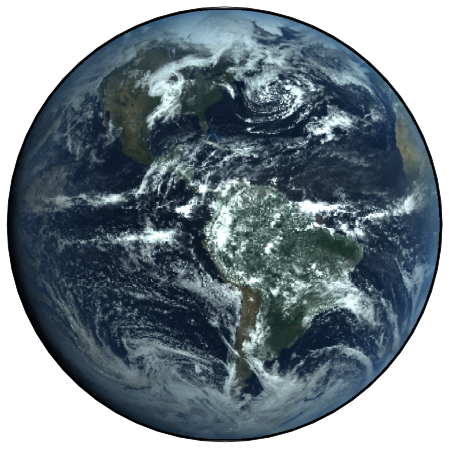

In [117]:
region = [180, -85, -180, 85]  # define bounding box to request data

fig = plt.figure(figsize=(10, 8))
projection = ccrs.Orthographic(central_longitude=-75.2)
# use cartoee to get a map
ax = cartoee.get_map(temp_image, region=region, vis_params=vis_params,proj=projection)

plt.show()

Pretty neat to view these data - in the desired projection - using matplotlib!
\
\
Now, we can use the entire image collection and save a gif to our local machine. As was done above, simply provide different gif parameters:

In [118]:
cartoee.get_image_collection_gif(
    ee_ic=col, #image collection object
    out_dir=os.path.expanduser("~/Downloads/timelapse"), #the filepath to put the individual gif images
    out_gif="goes_animation.gif", #the desired filename
    vis_params=vis_params,
    region=region,
    fps=5,
    mp4=True, #export an mp4 video in addition to the GIF
    grid_interval=(20, 20),
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png", #save all frames as individal png images
    verbose=True, #print the export status in real time
)

GIF saved to /Users/sfons/Downloads/timelapse/goes_animation.gif
MP4 saved to /Users/sfons/Downloads/timelapse/goes_animation.mp4


The above cell will download individual png images for each image in the Collection, and then combine the images to create both a GIF and an mp4 video.\
\
While this method is slightly more difficult than the original GIF-creation process shown in part 3, it does provde more flexibility especially when dealing with varying projections.